# Author: Gabriele Lorenzo



# Code

## CUDA Utilities

In [157]:
%%writefile cuda_stuff.cuh
#ifndef cuda_stuff_H
#define cuda_stuff_H

#include <stdio.h>
#include <stdlib.h>
#include <cuda.h>
#include <cuda_runtime.h>

//MACRO TO DEBUG CUDA FUNCTIONS
/** Error checking,
 *  taken from https://stackoverflow.com/questions/14038589/what-is-the-canonical-way-to-check-for-errors-using-the-cuda-runtime-api
 */
#define gpuErrchk(ans) { gpuAssert((ans), __FILE__, __LINE__); }
inline void gpuAssert(cudaError_t code, const char *file, int line, bool abort=true)
{
   if (code != cudaSuccess)
   {
      fprintf(stderr,"GPUassert: %s %s %d\n", cudaGetErrorString(code), file, line);
      if (abort) exit(code);
   }
}

void device_synchronize();

#endif


Overwriting cuda_stuff.cuh


In [158]:
%%writefile cuda_stuff.cu
#include <stdio.h>
#include <stdlib.h>
#include <cuda.h>
#include <cuda_runtime.h>

#include "cuda_stuff.cuh"

void device_synchronize(){
    gpuErrchk(cudaDeviceSynchronize());
}

Overwriting cuda_stuff.cu


## Matrix Tools

In [159]:
%%writefile fmatrix.cuh
#ifndef fmatrices_H
#define fmatrices_H
#include <stddef.h>

typedef struct {
    float* data;
    size_t cols;
    size_t rows;
} fmatrix;

/* transform matrix index to vector offset
   Since CUDA uses column major,
   nb_rows = number of rows */
#define IDX2C(i,j,nb_rows) (((j)*(nb_rows))+(i))

/* Access element (i,j) of matrix mat */
#define getfm(mat,i,j) (mat.data[IDX2C(i,j,mat.rows)])

size_t fmatrix_elements(fmatrix mat);
size_t fmatrix_size(fmatrix mat);
void fmatrix_init(fmatrix mat, float f);
/** Assert that the matrix is coherent: all fields nonzero. */
void fmatrix_assert();

fmatrix fmatrix_create_on_host(size_t rows, size_t cols);
fmatrix fmatrix_create_on_device(size_t rows, size_t cols);

void fmatrix_data_to_host(fmatrix mat_host, fmatrix mat_device);
void fmatrix_data_to_device(fmatrix mat_host, fmatrix mat_device);

void fmatrix_free_on_host(fmatrix* mat);
void fmatrix_free_on_device(fmatrix* mat);

/** Print the first nb rows of the matrix mat
 *  on the host.
 *  If nb<0, print all rows.
 */
void fmatrix_host_print(fmatrix mat, int nb=-1);

/** Print the first nb rows of the matrix mat
 *  on the device.
 *  If nb<0, print all rows.
 */
void fmatrix_device_print(fmatrix mat, int nb=-1);

#endif


Overwriting fmatrix.cuh


In [160]:
%%writefile fmatrix.cu
#include <assert.h>
#include <stdio.h>
#include <stdlib.h>
#include <cuda.h>
#include <cuda_runtime.h>

#include "cuda_stuff.cuh"
#include "fmatrix.cuh"

size_t fmatrix_elements(fmatrix mat) {
     return mat.cols*mat.rows;
}

size_t fmatrix_size(fmatrix mat) {
     return fmatrix_elements(mat) * sizeof(float);
}

void fmatrix_init(fmatrix mat, float f) {
    for (int i = 0; i < mat.rows; i++){
        for (int j = 0; j < mat.cols; j++){
            mat.data[IDX2C(i,j,mat.rows)] = f;
    }
  }
}

void fmatrix_assert(fmatrix mat) {
    assert(mat.data);
    assert(mat.cols);
    assert(mat.rows);
}

fmatrix fmatrix_create_on_host(size_t rows, size_t cols) {
    assert(cols>0);
    assert(rows>0);
    fmatrix mat;
    mat.cols = cols;
    mat.rows = rows;
    mat.data = (float*)malloc(fmatrix_size(mat));
    assert(mat.data);
    return mat;
}

fmatrix fmatrix_create_on_device(size_t rows, size_t cols) {
    assert(cols>0);
    assert(rows>0);
    fmatrix mat;
    mat.cols = cols;
    mat.rows = rows;
    gpuErrchk(
        cudaMalloc((void **)&(mat.data), fmatrix_size(mat))
    );
    return mat;
}

void fmatrix_data_to_device(fmatrix mat_host, fmatrix mat_device) {
    fmatrix_assert(mat_host);
    fmatrix_assert(mat_device);
    assert(mat_host.cols==mat_device.cols);
    assert(mat_host.rows==mat_device.rows);
    gpuErrchk(
        cudaMemcpy(mat_device.data, mat_host.data,
                   fmatrix_size(mat_host),
                   cudaMemcpyHostToDevice
                   )
        );
}

void fmatrix_data_to_host(fmatrix mat_host, fmatrix mat_device) {
    fmatrix_assert(mat_host);
    fmatrix_assert(mat_device);
    assert(mat_host.cols==mat_device.cols);
    assert(mat_host.rows==mat_device.rows);
    gpuErrchk(
        cudaMemcpy(mat_host.data, mat_device.data,
                   fmatrix_size(mat_device),
                   cudaMemcpyDeviceToHost
                   )
        );
}

void fmatrix_free_on_host(fmatrix* mat) {
    fmatrix_assert(*mat);
    free(mat->data);
    mat->data = 0;
    mat->cols = 0;
    mat->rows = 0;
}

void fmatrix_free_on_device(fmatrix* mat) {
    fmatrix_assert(*mat);
    gpuErrchk(cudaFree(mat->data));
    mat->data = 0;
    mat->cols = 0;
    mat->rows = 0;
}

void fmatrix_host_print(fmatrix mat, int nb){
    if (nb<0 || nb > mat.rows) {
        nb = mat.rows;
    }
    printf("[\n");
    for (int i = 0 ; i < nb; i++){
      for (int j = 0 ; j<mat.cols; j++){
        printf("%f", getfm(mat,i,j));
        if (j+1<mat.cols) {
          printf(",\t");
        }
      }
      if (i+1<nb) {
        printf(";\n");
      }
    }
    if (nb < mat.rows) {
      printf("\n...\n");
    }
  printf("\n]\n");
}

void fmatrix_device_print(fmatrix mat, int nb){
   // allocate copy
   fmatrix tmp = fmatrix_create_on_host(mat.rows, mat.cols);
   fmatrix_data_to_host(tmp, mat);
   fmatrix_host_print(tmp,nb);
   fmatrix_free_on_host(&tmp);
}



Overwriting fmatrix.cu


## Matrix Math

In [161]:
%%writefile sgemm.cuh
#ifndef sgemm_H
#define sgemm_H

#include <string>
#include "fmatrix.cuh"

void mat_mul(fmatrix A, fmatrix B, fmatrix C, std::string arg);

#endif

Overwriting sgemm.cuh


In [162]:
%%writefile sgemm.cu
#include <stdio.h>
#include <stdlib.h>
#include <string>
#include <time.h>
#include <math.h>
#include <cuda.h>
#include <cuda_runtime.h>
#include "cublas_v2.h"

#include "cuda_stuff.cuh"
#include "sgemm.cuh"
#include "fmatrix.cuh"

#define THREADS_PER_BLOCK 1024
#define TILE_WIDTH 32

using namespace std;

static cublasHandle_t handle;
static int cublas_init = 0;

/* basic matrix multiplication C = alpha*A*B + beta*C on host as reference for the speedup */
void matrixMultiplication_basic_host(float alpha, fmatrix A, fmatrix B, float beta, fmatrix C) {
  float tmp = 0;
  for (int i = 0; i<A.rows; i++){
    for (int j = 0; j<B.cols; j++){
      for (int k = 0; k<A.cols; k++){
        tmp += alpha * getfm(A, i, k) * getfm(B, k, j);
      }
      getfm(C, i, j) = beta * getfm(C, i, j) + tmp;
      tmp = 0;
    }
  }
}

/* TODO : 3 different versions of matrix multiplication C = alpha*A*B + beta*C on device */
__global__
void matmul_basic_kernel(float alpha, float *A, float *B, float beta, float *C, int nb_ColA, int nb_ColB, int nb_LigneA, int nb_LigneB) {
    /* TODO */
    int row = threadIdx.x + blockIdx.x * blockDim.x;
    int col = threadIdx.y + blockIdx.y * blockDim.y;

    if (row < nb_LigneA && col < nb_ColB) {
        float tmp = 0;
        for (int k = 0; k < nb_ColA; k++) {
            int idxA = IDX2C(row, k, nb_LigneA);
            int idxB = IDX2C(k, col, nb_ColB);
            tmp += alpha * A[idxA] * B[idxB];
        }
        int idxC = IDX2C(row, col, nb_LigneA);
        C[idxC] = beta * C[idxC] + tmp;
    }
}

void matrixMultiplication_basic(float alpha, fmatrix d_A, fmatrix d_B, float beta, fmatrix d_C) {
    int threads_per_block_2d = sqrt(THREADS_PER_BLOCK);

    dim3 dimBlock(threads_per_block_2d, threads_per_block_2d);
    dim3 dimGrid(ceil(d_A.rows / (float)threads_per_block_2d), ceil(d_B.cols / (float)threads_per_block_2d));

    matmul_basic_kernel <<< dimGrid, dimBlock >>> (alpha, d_A.data, d_B.data, beta, d_C.data, d_A.cols, d_B.cols, d_A.rows, d_B.rows);
    gpuErrchk(cudaPeekAtLastError());
    device_synchronize();
}


/**********************/
__global__
void matmul_tiled_kernel(float alpha, float *A, float *B, float beta, float *C, int nb_ColA, int nb_ColB, int nb_LigneA, int nb_LigneB) {
    __shared__ float As[TILE_WIDTH][TILE_WIDTH];
    __shared__ float Bs[TILE_WIDTH][TILE_WIDTH];

    int row = blockIdx.y * TILE_WIDTH + threadIdx.y;
    int col = blockIdx.x * TILE_WIDTH + threadIdx.x;
    float tmp = 0.0f;

    for (int t = 0; t < (nb_ColA + TILE_WIDTH - 1) / TILE_WIDTH; t++) {
        // Load tiles into shared memory with boundary checks
        As[threadIdx.y][threadIdx.x] = (row < nb_LigneA && (t * TILE_WIDTH + threadIdx.x) < nb_ColA) ? A[row * nb_ColA + t * TILE_WIDTH + threadIdx.x] : 0.0f;
        Bs[threadIdx.y][threadIdx.x] = (col < nb_ColB && (t * TILE_WIDTH + threadIdx.y) < nb_LigneB) ? B[(t * TILE_WIDTH + threadIdx.y) * nb_ColB + col] : 0.0f;

        __syncthreads(); // Ensure the tile is fully loaded

        for (int k = 0; k < TILE_WIDTH; k++) {
            tmp += As[threadIdx.y][k] * Bs[k][threadIdx.x];
        }
        __syncthreads(); // Ensure threads finish computation before loading new tile
    }

    if (row < nb_LigneA && col < nb_ColB) {
        int idxC = IDX2C(row, col, nb_ColB);
        C[idxC] = beta * C[idxC] + alpha * tmp;
    }
}

void matrixMultiplication_tiled(float alpha, fmatrix d_A, fmatrix d_B, float beta, fmatrix d_C){
  // TODO - declaration of dimGrid and dimBlock
    dim3 dimBlock(TILE_WIDTH, TILE_WIDTH);
    dim3 dimGrid(ceil(d_A.rows / (float) dimBlock.x), ceil(d_B.cols / (float) dimBlock.y));

    matmul_tiled_kernel <<< dimGrid, dimBlock >>> (alpha, d_A.data, d_B.data, beta, d_C.data, d_A.cols, d_B.cols, d_A.rows, d_B.rows);
    gpuErrchk(cudaPeekAtLastError());
    device_synchronize();
}

/**********************/
void matrixMultiplication_cublas(float alpha, fmatrix d_A, fmatrix d_B, float beta, fmatrix d_C){
  /* TODO */
  if (!cublas_init) {
    cublasCreate(&handle);
    cublas_init = 1;
  }

  float *d_A_data = d_A.data;
  float *d_B_data = d_B.data;
  float *d_C_data = d_C.data;

  cublasSgemm(handle, CUBLAS_OP_N, CUBLAS_OP_N, d_A.rows, d_B.cols, d_A.cols, &alpha, d_A_data, d_A.rows, d_B_data, d_B.rows, &beta, d_C_data, d_C.rows);

  gpuErrchk(cudaPeekAtLastError());
  gpuErrchk(cudaDeviceSynchronize());
}

/*MAIN SGEMM*/
void gen_mat_mul(float alpha, fmatrix A, fmatrix B, float beta, fmatrix C, std::string arg){
    if (arg == "cpu"){
        matrixMultiplication_basic_host(alpha, A, B, beta, C);
    } else {
        /* kernel function*/
        if (arg == "gpu_basic"){
            matrixMultiplication_basic(alpha, A, B, beta, C);
        } else if (arg == "gpu_tiled"){
            matrixMultiplication_tiled(alpha, A, B, beta, C);
        } else if (arg == "gpu_cublas"){
            matrixMultiplication_cublas(alpha, A, B, beta, C);
        } else{
            printf("Matrix Multiplication argument is Wrong");
            exit(0);
        }
        // wait for everything to finish
        device_synchronize();
    }
}

void mat_mul(fmatrix A, fmatrix B, fmatrix C, std::string arg){
    gen_mat_mul(1.0, A, B, 0.0, C, arg);
}


Overwriting sgemm.cu


# Main

In [163]:
%%writefile main.cu

#include <stdio.h>
#include <stdlib.h>
#include "fmatrix.cuh"
#include "sgemm.cuh"

#define TILE_WIDTH 32
#define SIZE 1280
#define N_RUNS 5

int main(void) {
  /* Allocate and initialize data on host */
  fmatrix A = fmatrix_create_on_host(SIZE, SIZE);
  fmatrix_init(A, 1.0);
  fmatrix B = fmatrix_create_on_host(SIZE, SIZE);
  fmatrix_init(B, 2.0);
  fmatrix C = fmatrix_create_on_host(SIZE, SIZE);
  fmatrix_init(C, 0.0);

  /* Allocate data on device */
  fmatrix d_A = fmatrix_create_on_device(SIZE, SIZE);
  fmatrix d_B = fmatrix_create_on_device(SIZE, SIZE);
  fmatrix d_C = fmatrix_create_on_device(SIZE, SIZE);

  /* Transfer A and B on device */
  fmatrix_data_to_device(A, d_A);
  fmatrix_data_to_device(B, d_B);
  fmatrix_data_to_device(C, d_C);

  clock_t start, end;
  float total_exec_time = 0;

  /* Start calculation "cpu", "gpu_basic", "gpu_tiled", "gpu_cublas" */
  /************** "cpu" *******************/
  for (int i = 0; i < N_RUNS; i++) {
    start = clock();
    mat_mul(A, B, C, "cpu");
    end = clock();
    total_exec_time += ((double) (end - start)) * 1000 / CLOCKS_PER_SEC;
  }
  printf("Time taken by CPU in milliseconds: %.2f\n", total_exec_time / N_RUNS);

  /* Result correctness */
  {
    float maxError = 0.0f;
    for (int i = 0; i < SIZE; i++){
      for (int j = 0; j < SIZE; j++){
        maxError = max(maxError, abs(getfm(C,i,j)- 2*SIZE));
      }
    }
    printf("Max error: %f\n", maxError);
  }
  fmatrix_init(C, 0.0);

  /************** "gpu_basic" *******************/
  total_exec_time = 0;
  for (int i = 0; i < N_RUNS; i++) {
    start = clock();
    mat_mul(d_A, d_B, d_C, "gpu_basic");
    end = clock();
    total_exec_time += ((double) (end - start)) * 1000 / CLOCKS_PER_SEC;
  }
  printf("GPU basic matrix multiplication in milliseconds: %.2f\n", total_exec_time / N_RUNS);

  /* Retrieve the result */
  fmatrix_data_to_host(C, d_C);
  /* Result correctness */
  {
    float maxError = 0.0f;
    for (int i = 0; i < SIZE; i++){
      for (int j = 0; j < SIZE; j++){
        maxError = max(maxError, abs(getfm(C,i,j)- 2*SIZE));
      }
    }
    printf("Max error: %f\n", maxError);
  }
  fmatrix_init(C, 0.0);
  fmatrix_data_to_device(C, d_C);


 /************** "gpu_tiled" *******************/
  total_exec_time = 0;
  for (int i = 0; i < N_RUNS; i++) {
    start = clock();
    mat_mul(d_A, d_B, d_C, "gpu_tiled");
    end = clock();
    total_exec_time += ((double) (end - start)) * 1000 / CLOCKS_PER_SEC;
  }
  printf("GPU tiled matrix multiplication in milliseconds: %.2f\n", total_exec_time / N_RUNS);

  /* Retrieve the result */
  fmatrix_data_to_host(C, d_C);
  /* Result correctness */
  {
    float maxError = 0.0f;
    for (int i = 0; i < SIZE; i++){
      for (int j = 0; j < SIZE; j++){
        maxError = max(maxError, abs(getfm(C,i,j)- 2*SIZE));
      }
    }
    printf("Max error: %f\n", maxError);
  }
  fmatrix_init(C, 0.0);
  fmatrix_data_to_device(C, d_C);


  /************** "gpu_cublas" *******************/
  for(int warmup = 0; warmup < 5; warmup++){
    mat_mul(d_A, d_B, d_C, "gpu_cublas");
  }
  fmatrix_init(C, 0.0);
  fmatrix_data_to_device(C, d_C);

  total_exec_time = 0;
  for (int i = 0; i < N_RUNS; i++) {
    start = clock();
    mat_mul(d_A, d_B, d_C, "gpu_cublas");
    end = clock();
    total_exec_time += ((double) (end - start)) * 1000 / CLOCKS_PER_SEC;
  }
  printf("GPU cuBLAS matrix multiplication in milliseconds: %.2f\n", total_exec_time / N_RUNS);

  /* Retrieve the result */
  fmatrix_data_to_host(C, d_C);
  /* Result correctness */
  {
    float maxError = 0.0f;
    for (int i = 0; i < SIZE; i++){
      for (int j = 0; j < SIZE; j++){
        maxError = max(maxError, abs(getfm(C,i,j)- 2*SIZE));
      }
    }
    printf("Max error: %f\n", maxError);
  }
  fmatrix_init(C, 0.0);
  fmatrix_data_to_device(C, d_C);

  /* Free */
  fmatrix_free_on_host(&A);
  fmatrix_free_on_host(&B);
  fmatrix_free_on_host(&C);
  fmatrix_free_on_device(&d_A);
  fmatrix_free_on_device(&d_B);
  fmatrix_free_on_device(&d_C);
}

Overwriting main.cu


# Compiling

In [164]:
!nvcc -lcublas sgemm.cu  fmatrix.cu  cuda_stuff.cu main.cu -arch=sm_75 -o main

# Experiments

In [165]:
! ./main

^C


# Debugging
Compile with debugging info on the host (`-g`) and device (`-G`).


In [166]:
!nvcc -g -G -I /usr/local/cuda/samples/common/inc/ -L/usr/local/cuda/include -lcublas -lcusolver sgemm.cu fmatrix.cu cuda_stuff.cu main.cu

nvcc error   : 'gcc' died due to signal 2 


Run the debugger cuda-gdb, stopping at the first error that is detected. Shows first the call stack on the GPU, the values of local variables, then the call stack on the host (thread 1).

In [167]:
! printf "set cuda api_failures stop\ncatch throw\nr UNIT\nbt\ninfo locals\nthread 1\nbt\n" > tmp.txt
! cat tmp.txt
! cuda-gdb -batch -x tmp.txt ./a.out

set cuda api_failures stop
catch throw
r UNIT
bt
info locals
thread 1
bt
Catchpoint 1 (throw)
[Thread debugging using libthread_db enabled]
Using host libthread_db library "/lib/x86_64-linux-gnu/libthread_db.so.1".
[New Thread 0x7fffd013c000 (LWP 10930)]
[New Thread 0x7fffcedff000 (LWP 10931)]
[Detaching after fork from child process 10932]
[New Thread 0x7fffcd2e2000 (LWP 10937)]

Thread 1 "a.out" received signal SIGINT, Interrupt.
0x000055555555fe0e in matrixMultiplication_basic_host (alpha=1, A=..., B=..., beta=0, C=...) at /content/sgemm.cu:28
28	        tmp += alpha * getfm(A, i, k) * getfm(B, k, j);
#0  0x000055555555fe0e in matrixMultiplication_basic_host (alpha=1, A=..., B=..., beta=0, C=...) at /content/sgemm.cu:28
#1  0x00005555555603d2 in gen_mat_mul (alpha=1, A=..., B=..., beta=0, C=..., arg=...) at /content/sgemm.cu:127
#2  0x0000555555560569 in mat_mul (A=..., B=..., C=..., arg=...) at /content/sgemm.cu:146
#3  0x00005555555619ab in main () at /content/main.cu:37
k = 1049


# Analysis

The execution times values are hardcoded for simplicity

In [173]:
import re
import matplotlib.pyplot as plt
import numpy as np

execution_times = [
    {
        "CPU": 15623.00,
        "GPU Basic": 12.90,
        "GPU Tiled-TW8": 16.51,
        "GPU Tiled-TW16": 10.86,
        "GPU Tiled-TW32": 10.58,
        "GPU cuBLAS": 1.03,
    },
    {
        "CPU": 1109.42,
        "GPU Basic": 1.63,
        "GPU Tiled-TW8": 2.27,
        "GPU Tiled-TW16": 1.48,
        "GPU Tiled-TW32": 1.40,
        "GPU cuBLAS": 0.25,
    },
    {
        "CPU": 129.65,
        "GPU Basic": 0.29,
        "GPU Tiled-TW8": 0.30,
        "GPU Tiled-TW16": 0.21,
        "GPU Tiled-TW32": 0.24,
        "GPU cuBLAS": 0.07,
    },
]
m_size = [1280, 640, 320]
labels = ["CPU", "GPU Basic", "GPU Tiled-TW8", "GPU Tiled-TW16", "GPU Tiled-TW32", "GPU cuBLAS"]

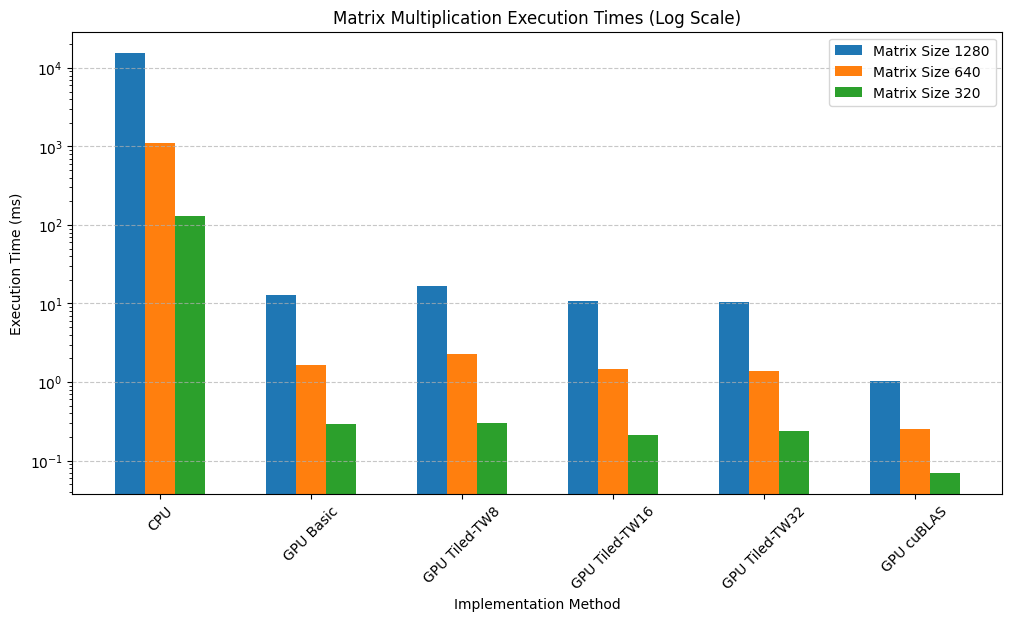

In [174]:


def plot_times(execution_times, m_size, labels):
    num_methods = len(labels)
    num_sizes = len(m_size)

    times_matrix = np.array([[run[label] for label in labels] for run in execution_times])

    x = np.arange(num_methods)
    width = 0.2

    plt.figure(figsize=(12, 6))

    for i, (size, times) in enumerate(zip(m_size, times_matrix)):
        plt.bar(x + i * width, times, width, label=f'Matrix Size {size}')

    plt.xlabel("Implementation Method")
    plt.ylabel("Execution Time (ms)")
    plt.yscale("log")
    plt.title("Matrix Multiplication Execution Times (Log Scale)")
    plt.xticks(x + width, labels, rotation=45)
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    plt.show()

plot_times(execution_times, m_size, labels)

As we can see from the plot the CPU implementation is by far the slowest one. This is expected since we are using no parallelization.

 In contrast, all GPU implementations achieve significantly lower execution times, benefiting from thousands of parallel cores that accelerate matrix multiplication.

 The cuBLAS library, specifically optimized for NVIDIA GPUs, delivers the fastest execution.

 Among the tiled GPU implementations, the performance varies slightly with tile size, lower values of tile width give slower execution times, as expected.


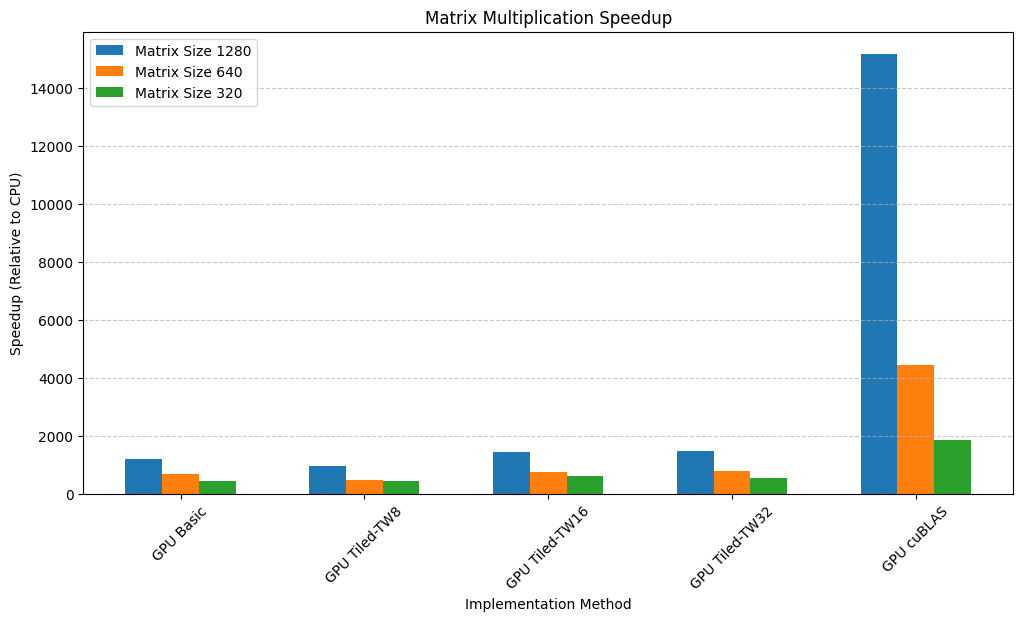

In [175]:
def plot_speedup(execution_times, m_size, labels):
    num_methods = len(labels) - 1
    num_sizes = len(m_size)

    # Compute speedup: CPU time divided by other method times
    speedup_matrix = np.array([
        [run["CPU"] / run[label] for label in labels[1:]]
        for run in execution_times
    ])

    x = np.arange(num_methods)
    width = 0.2

    plt.figure(figsize=(12, 6))

    for i, (size, speedups) in enumerate(zip(m_size, speedup_matrix)):
        plt.bar(x + i * width, speedups, width, label=f'Matrix Size {size}')

    plt.xlabel("Implementation Method")
    plt.ylabel("Speedup (Relative to CPU)")
    plt.title("Matrix Multiplication Speedup")
    plt.xticks(x + width, labels[1:], rotation=45)
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    plt.show()

plot_speedup(execution_times, m_size, labels)

This plot illustrates the speedup achieved by different GPU implementations relative to the CPU.

The GPU cuBLAS implementation significantly outperforms all others, achieving the highest speedup, particularly for the largest matrix size (1280).

The other GPU implementations also show substantial acceleration, with all achieving at least an order of magnitude improvement over the CPU.

Interestingly, speedup increases with matrix size, as larger matrices provide more opportunities for parallelism, allowing the GPU to better utilize its computational resources.

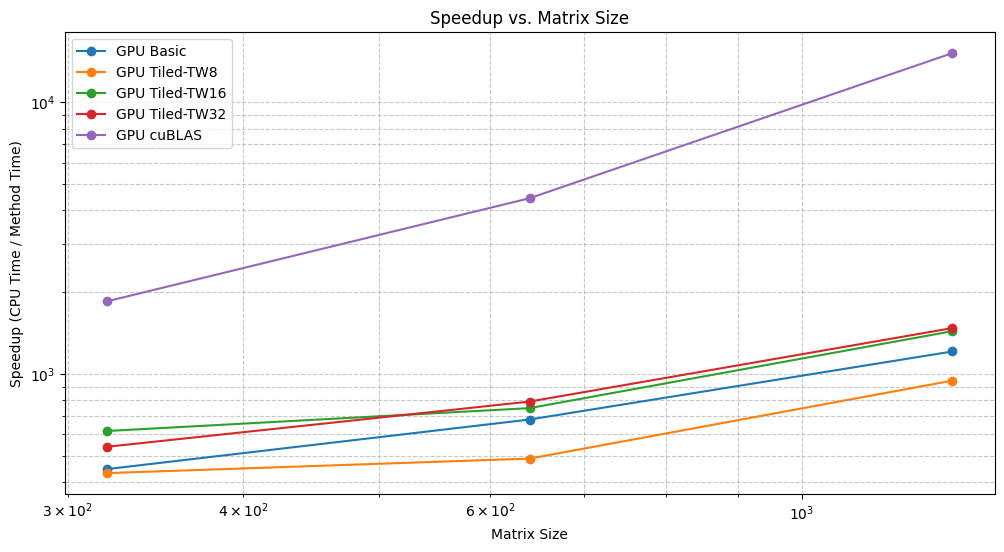

In [176]:
def plot_speedup_vs_msize(execution_times, m_size, labels):
    speedups = []
    methods = labels[1:]

    for run in execution_times:
        cpu_time = run["CPU"]
        speedups.append([cpu_time / run[method] for method in methods])

    speedups = np.array(speedups)

    plt.figure(figsize=(12, 6))
    for i, method in enumerate(methods):
        plt.plot(m_size, speedups[:, i], marker='o', label=method)

    plt.xlabel("Matrix Size")
    plt.ylabel("Speedup (CPU Time / Method Time)")
    plt.xscale("log")
    plt.yscale("log")
    plt.title("Speedup vs. Matrix Size")
    plt.legend()
    plt.grid(True, which="both", linestyle="--", alpha=0.7)
    plt.show()

plot_speedup_vs_msize(execution_times, m_size, labels)

This plot illustrates the relationship between speedup and matrix size for various GPU implementations.

As expected, speedup generally increases with matrix size, highlighting the advantages of GPU parallelization for larger workloads.

The cuBLAS implementation exhibits the highest speedup across all matrix sizes, reinforcing its superior optimization.

The tiled implementations (TW8, TW16, and TW32) follow a similar trend, with larger tile sizes (TW32) achieving slightly better performance.

 Overall, this plot confirms that GPUs become increasingly efficient as the computational workload grows.